Generate 1 random point for each 100 jobs in every block group, and apply HDBSCAN to identify clusters in each city. Then select largest/most central cluster in each city to be downtown. Do this for US and Canada.

### Install/load packages

In [ ]:
# pip install folium matplotlib mapclassify 
# import sys
# !{sys.executable} -m pip install contextily

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib
import mapclassify
import numpy as np
import shapely
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import hdbscan
import contextily as cx

C:\Users\jpg23\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jpg23\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\jpg23\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Combine US and Canada data

In [2]:
data_path = "C:/Users/jpg23/data/downtownrecovery/lehd_new_downtowns/"

In [3]:
# canada = gpd.read_file(data_path + "canada_DA_jobs.geojson") # Canada
# us_bg = gpd.read_file(data_path + "cities_lehd_jobs_blockgroup.geojson") # US - block group

In [4]:
# canada.head()

id  total_jobs     province  CMANAME          area  \
0  12090733       895.0  nova_scotia  Halifax  6.502163e+06   
1  12090267       105.0  nova_scotia  Halifax  2.460350e+05   
2  12090270        60.0  nova_scotia  Halifax  1.295102e+05   
3  12090521       260.0  nova_scotia  Halifax  8.271270e+05   
4  12090523       100.0  nova_scotia  Halifax  1.280014e+06   

   jobs_per_sq_meter                                           geometry  
0           0.000138  POLYGON ((8420792.99143 1442444.80572, 8420836...  
1           0.000427  POLYGON ((8411796.44286 1435497.92571, 8411825...  
2           0.000463  POLYGON ((8412191.61143 1435034.62285, 8412189...  
3           0.000314  POLYGON ((8405601.42571 1441711.98286, 8405668...  
4           0.000078  POLYGON ((8403102.94857 1442184.36857, 8403754...

In [5]:
# canada_sf = gpd.read_file(data_path + "reprojected_canada_DA.geojson")[['DAUID', 'geometry']]

In [6]:
# canada_sf.head()

DAUID                                           geometry
0  10010244  MULTIPOLYGON (((-52.76815 47.55803, -52.76902 ...
1  10010245  MULTIPOLYGON (((-52.75476 47.56543, -52.75689 ...
2  10010246  MULTIPOLYGON (((-52.75059 47.56404, -52.75143 ...
3  10010247  MULTIPOLYGON (((-52.74770 47.56475, -52.74816 ...
4  10010248  MULTIPOLYGON (((-52.74218 47.56276, -52.74513 ...

In [7]:
# canada.id.nunique()

18338

In [8]:
# canada_sf.DAUID.nunique()

56589

In [9]:
# canada_newgeom = canada_sf.merge(canada.drop('geometry', axis=1), left_on='DAUID', right_on='id', how='inner').drop(columns = ['DAUID'])

In [10]:
# canada_newgeom.head()

geometry        id  total_jobs  \
0  MULTIPOLYGON (((-63.47690 44.62769, -63.47650 ...  12090733       895.0   
1  MULTIPOLYGON (((-63.61425 44.60654, -63.61402 ...  12090267       105.0   
2  MULTIPOLYGON (((-63.61230 44.60135, -63.61233 ...  12090270        60.0   
3  MULTIPOLYGON (((-63.65043 44.67958, -63.64985 ...  12090521       260.0   
4  MULTIPOLYGON (((-63.67586 44.69282, -63.67091 ...  12090523       100.0   

      province  CMANAME          area  jobs_per_sq_meter  
0  nova_scotia  Halifax  6.502163e+06           0.000138  
1  nova_scotia  Halifax  2.460350e+05           0.000427  
2  nova_scotia  Halifax  1.295102e+05           0.000463  
3  nova_scotia  Halifax  8.271270e+05           0.000314  
4  nova_scotia  Halifax  1.280014e+06           0.000078

In [11]:
# canada_newgeom.id.nunique()

18338

In [12]:
# us_bg.head()

state   block_group  land_area  total_jobs        city  jobs_per_sq_meter  \
0    AZ  040131037021     603072       741.0  Phoenix AZ           0.001229   
1    AZ  040131047012     263094       490.0  Phoenix AZ           0.001862   
2    AZ  040131091012     507883        83.0  Phoenix AZ           0.000163   
3    AZ  040131136021     427255        80.0  Phoenix AZ           0.000187   
4    AZ  040131072011     853700      9581.0  Phoenix AZ           0.011223   

                                            geometry  
0  POLYGON ((-112.05651 33.58952, -112.05212 33.5...  
1  POLYGON ((-112.06514 33.58041, -112.06510 33.5...  
2  POLYGON ((-112.12558 33.50640, -112.12380 33.5...  
3  POLYGON ((-112.01291 33.45857, -112.01285 33.4...  
4  POLYGON ((-112.13423 33.51673, -112.12559 33.5...

In [13]:
# canada_newgeom.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
# us_bg.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [15]:
# # reproject so they're in the same CRS
# us_bg_reproj = us_bg.to_crs('EPSG:4326')

In [16]:
# us_bg_reproj.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
# us_bg_reproj.crs == canada_newgeom.crs

True

In [18]:
# # gut check - are jobs_per_sq_meter relatievly similar for US & Canada?
# print(canada_newgeom.jobs_per_sq_meter.mean())
# us_bg_reproj.jobs_per_sq_meter.mean()

0.0019885360736815656


0.0031908496741493222

In [19]:
# print(canada_newgeom.jobs_per_sq_meter.median())
# us_bg_reproj.jobs_per_sq_meter.median()

0.0006380857815472697


0.0004892612509486287

In [20]:
# # stack the datasets
# canada_final = canada_newgeom.rename(columns={"CMANAME": "place"})[['id', 'total_jobs', 'jobs_per_sq_meter', 'place', 'geometry']]

# us_bg_final = us_bg_reproj.rename(columns={"block_group":"id", "city":"place"})[['id', 'total_jobs', 'jobs_per_sq_meter', 'place', 'geometry']]

In [21]:
# df = pd.concat([us_bg_final, canada_final])

In [22]:
# df.head()

id  total_jobs  jobs_per_sq_meter       place  \
0  040131037021       741.0           0.001229  Phoenix AZ   
1  040131047012       490.0           0.001862  Phoenix AZ   
2  040131091012        83.0           0.000163  Phoenix AZ   
3  040131136021        80.0           0.000187  Phoenix AZ   
4  040131072011      9581.0           0.011223  Phoenix AZ   

                                            geometry  
0  POLYGON ((-112.05651 33.58952, -112.05212 33.5...  
1  POLYGON ((-112.06514 33.58041, -112.06510 33.5...  
2  POLYGON ((-112.12558 33.50640, -112.12380 33.5...  
3  POLYGON ((-112.01291 33.45857, -112.01285 33.4...  
4  POLYGON ((-112.13423 33.51673, -112.12559 33.5...

In [23]:
# df.place.unique()

array(['Phoenix AZ', 'Tucson AZ', 'Memphis TN', 'San Francisco CA',
       'Sacramento CA', 'San Diego CA', 'Bakersfield CA', 'Oakland CA',
       'San Jose CA', 'Los Angeles CA', 'Fresno CA', 'Denver CO',
       'Colorado Springs CO', 'Orlando FL', 'Miami FL', 'Jacksonville FL',
       'Tampa FL', 'Atlanta GA', 'Urban Honolulu HI', 'Chicago IL',
       'St. Louis MO', 'Indianapolis city (balance) IN', 'Louisville KY',
       'Omaha NE', 'Kansas City MO', 'Cincinnati OH', 'New Orleans LA',
       'Baltimore MD', 'Washington DC', 'Boston MA', 'Detroit MI',
       'Minneapolis MN', 'Las Vegas NV', 'Philadelphia PA', 'New York NY',
       'Albuquerque NM', 'El Paso TX', 'Raleigh NC', 'Charlotte NC',
       'Columbus OH', 'Cleveland OH', 'Oklahoma City OK', 'Tulsa OK',
       'Portland OR', 'Pittsburgh PA',
       'Nashville-Davidson metropolitan government (balance) TN',
       'Austin TX', 'Houston TX', 'Fort Worth TX', 'San Antonio TX',
       'Dallas TX', 'Salt Lake City UT', 'Seattle 

In [24]:
# df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
# # Drop the Quebec part of Ottawa
# df = df[df['place']!='Ottawa - Gatineau (partie du Québec / Quebec part)']

In [26]:
# df.place.unique()

array(['Phoenix AZ', 'Tucson AZ', 'Memphis TN', 'San Francisco CA',
       'Sacramento CA', 'San Diego CA', 'Bakersfield CA', 'Oakland CA',
       'San Jose CA', 'Los Angeles CA', 'Fresno CA', 'Denver CO',
       'Colorado Springs CO', 'Orlando FL', 'Miami FL', 'Jacksonville FL',
       'Tampa FL', 'Atlanta GA', 'Urban Honolulu HI', 'Chicago IL',
       'St. Louis MO', 'Indianapolis city (balance) IN', 'Louisville KY',
       'Omaha NE', 'Kansas City MO', 'Cincinnati OH', 'New Orleans LA',
       'Baltimore MD', 'Washington DC', 'Boston MA', 'Detroit MI',
       'Minneapolis MN', 'Las Vegas NV', 'Philadelphia PA', 'New York NY',
       'Albuquerque NM', 'El Paso TX', 'Raleigh NC', 'Charlotte NC',
       'Columbus OH', 'Cleveland OH', 'Oklahoma City OK', 'Tulsa OK',
       'Portland OR', 'Pittsburgh PA',
       'Nashville-Davidson metropolitan government (balance) TN',
       'Austin TX', 'Houston TX', 'Fort Worth TX', 'San Antonio TX',
       'Dallas TX', 'Salt Lake City UT', 'Seattle 

In [27]:
# type(df)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

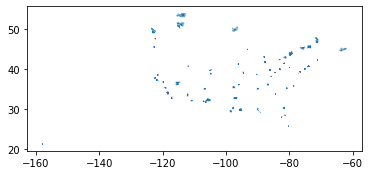

In [28]:
# df.plot()

In [ ]:
# # Look at Tampa as an example
# tampa = df[df['place']=='Tampa FL']

In [ ]:
# tampa.explore(
#     tooltip="id",
#     tiles="CartoDB positron",
#     style_kwds=dict(color="black")
# )

### In each block group/dissemination area, randomly scatter 1 point for every 100 jobs

In [29]:
# # scatter random points in polygon

# def Random_Points_in_Bounds(polygon, number):   
#     minx, miny, maxx, maxy = polygon.bounds
#     x = np.random.uniform(minx, maxx, number*4)
#     y = np.random.uniform(miny, maxy, number*4)
#     gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[polygon])
#     df = pd.DataFrame()
#     df['points'] = list(zip(x,y))
#     df['points'] = df['points'].apply(shapely.geometry.Point)
#     gdf_points = gpd.GeoDataFrame(df, geometry='points')
#     Sjoin = gpd.sjoin(gdf_points, gdf_poly, op="within", how='left')
#     pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']
#     return pnts_in_poly['points'].tolist()[0:number]

In [ ]:
# # divide # of total jobs by 100
# df['jobs_hundreds'] = round((df['total_jobs']/100), 0)

# # filter to only block groups / dissemination areas where there are at least 100 jobs
# df_100 = df[df['jobs_hundreds']>0].copy()

# # create randomly scattered points in each block group / dissemination area
# df_100['points'] = df_100[['geometry', 'jobs_hundreds']].apply(lambda x: Random_Points_in_Bounds(x[0], int(x[1])), axis=1)

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  results[i] = self.f(v)
C:\Users\jpg23\anaconda3\lib\site-packages\pandas\core\apply.py:305: FutureWarning: 

In [ ]:
# df_100.head()

In [ ]:
# # create a row for each set of points
# df_100_points = df_100.explode('points')

In [ ]:
# df_100_points.head()

In [ ]:
# type(df_100_points)

In [ ]:
# # initialize format for dbscan
# df_dbscan = gpd.GeoDataFrame(df_100_points[['id', 'points', 'jobs_per_sq_meter', 'place']].copy(), geometry='points')
# df_dbscan['point_lon'] = df_dbscan['points'].x
# df_dbscan['point_lat'] = df_dbscan['points'].y

In [ ]:
# df_dbscan.head()

In [ ]:
# df_dbscan.to_file(data_path + 'blockgroup_random_pts.geojson', driver='GeoJSON')  

In [ ]:
df_dbscan = gpd.read_file(data_path + "blockgroup_random_pts.geojson")

### Apply HDBSCAN to determine clusters in each city

See [hdbscan documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html) and [documentation on parameter selection](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html).

In [ ]:
df_dbscan_notnull = df_dbscan[df_dbscan['point_lon'].notna()]

In [ ]:
# what % of rows were not NA?
df_dbscan_notnull.shape[0]/df_dbscan.shape[0]

In [ ]:
# standardize lat/long values
X = StandardScaler().fit_transform(df_dbscan_notnull[['point_lon', 'point_lat']].copy())

In [ ]:
type(X)

In [ ]:
X

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=25,
                           core_dist_n_jobs=1)

In [ ]:
clusterer.fit(X)

In [ ]:
# find number of labels

np.max(clusterer.labels_)

In [ ]:
# append results to original database

df_dbscan_notnull['cluster'] = clusterer.labels_
df_dbscan_notnull.head()

In [ ]:
df_dbscan_notnull.cluster.unique()

In [ ]:
df_dbscan_notnull.head()

### Explore points in specific cities

In [ ]:
# create map of all points in city
def explore_pts(city_name):
    pts_only_city = df_dbscan_notnull[df_dbscan_notnull['place']==city_name].set_crs(4326)
    
#     ax = pts_only_city.plot(figsize=(9, 9), alpha=0.5)
#     cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=4326)

    return(pts_only_city.explore(
        tiles="CartoDB positron",
        style_kwds=dict(opacity=.5, fillOpacity=.5)
    ))

In [ ]:
explore_pts('San Francisco CA')

In [ ]:
explore_pts('Nashville-Davidson metropolitan government (balance) TN')

In [ ]:
explore_pts('Portland OR')

### Explore clusters in specific cities

In [ ]:
# Filter out non-clustered points and set CRS
clusters_only = df_dbscan_notnull[df_dbscan_notnull["cluster"]!=-1].set_crs(4326)
clusters_only['cluster'] = clusters_only['cluster'].astype(str)

In [ ]:
# create interactive map of clusters
def explore_clusters(city_name):
    
    clusters_only_city = clusters_only[clusters_only['place']==city_name]
    
    return(clusters_only_city.explore(
        column="cluster",
        tiles="CartoDB positron",
        style_kwds=dict(opacity=.5, fillOpacity=.5),
        cmap='Spectral'
    ))

In [ ]:
explore_clusters('San Francisco CA')

In [ ]:
explore_clusters('Calgary')

In [ ]:
explore_clusters('Albuquerque NM')

In [ ]:
explore_clusters('New York NY')

In [ ]:
explore_clusters('Philadelphia PA')

In [ ]:
explore_clusters('Nashville-Davidson metropolitan government (balance) TN')

### Choose largest/most central cluster in each city for downtown

Map block groups/dissemination areas to clusters. (HOW???)

In [ ]:
# clusters_only['count'] = 1
# grouped_clust = clusters_only.groupby(['id','cluster'])['count'].sum().reset_index()

In [ ]:
# # Merge the count data back into the original DataFrame
# merged_df = pd.merge(clusters_only.drop(columns=['count']), grouped_clust, on=['id', 'cluster'], how='left')
# merged_df.head()

In [ ]:
# # are there IDs with multiple clusters?
# multiple_clust = merged_df.join(merged_df.groupby('id')['cluster'].nunique(), on='id', rsuffix='_r').sort_values(by=['cluster_r', 'id'], ascending=False)
# multiple_clust.head()

In [ ]:
# # look at one in the US
# multiple_clust[multiple_clust['place'].str.contains('\s\w{2}$')].head()

REMEMBER TO SELECT TWO IN TORONTO CMA -- ONE FOR TORONTO AND ONE FOR MISSISSAUGA!

### Combine all downtown polygons and export as a single shapefile